<a href="https://colab.research.google.com/github/mphuong1209/midterm_exam_computer_vision/blob/main/Dinh_Le_Minh_Phuong_22070855.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part A – Image Filtering


In [1]:
from google.colab import files

uploaded = files.upload()

Saving image.jpg to image.jpg


In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [73]:
img = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)

In [74]:
# Apply Gaussian
noise = np.random.normal(0, 20, img.shape).astype(np.uint8)
noisy_img = cv2.add(img, noise)

In [75]:
# Apply filters
mean_filtered = cv2.blur(noisy_img, (5, 5))
gaussian_filtered = cv2.GaussianBlur(noisy_img, (5, 5), 0)
median_filtered = cv2.medianBlur(noisy_img, 5)
laplacian = cv2.Laplacian(noisy_img, cv2.CV_64F)
laplacian = np.uint8(np.clip(laplacian, 0, 255))
sharpened = cv2.addWeighted(noisy_img, 1, laplacian, -1, 0)

In [76]:
# Calculate PSNR
def psnr(original, filtered):
    mse = np.mean((original.astype(np.float32) - filtered.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

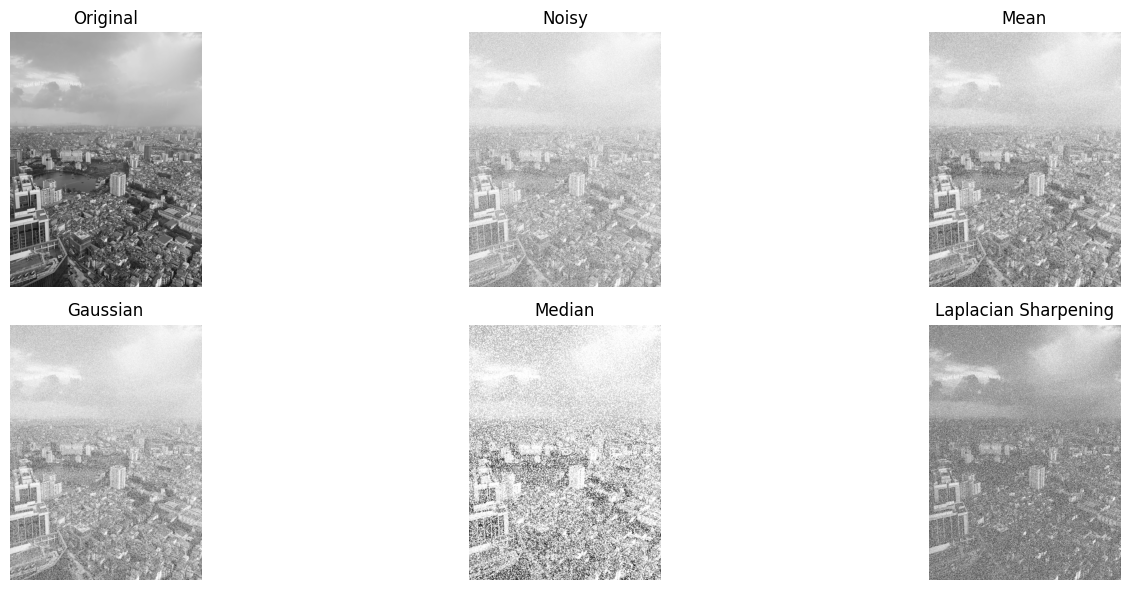

🔎 PSNR values (compared to original image):
Mean: 10.82 dB
Gaussian: 10.83 dB
Median: 8.74 dB
Laplacian Sharpening: 6.99 dB


In [77]:
# Show Image
titles = ['Original', 'Noisy', 'Mean', 'Gaussian', 'Median', 'Laplacian Sharpening']
images = [img, noisy_img, mean, gaussian, median, sharpened]

plt.figure(figsize=(16, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Calculate and print PSNR
print("🔎 PSNR values (compared to original image):")
for name, filtered in zip(titles[2:], images[2:]):
    print(f"{name}: {psnr(img, filtered):.2f} dB")

Part B – 3D Reconstruction

In [9]:
from google.colab import files

uploaded = files.upload()

Saving teddy_left.png to teddy_left.png
Saving teddy_right.png to teddy_right.png


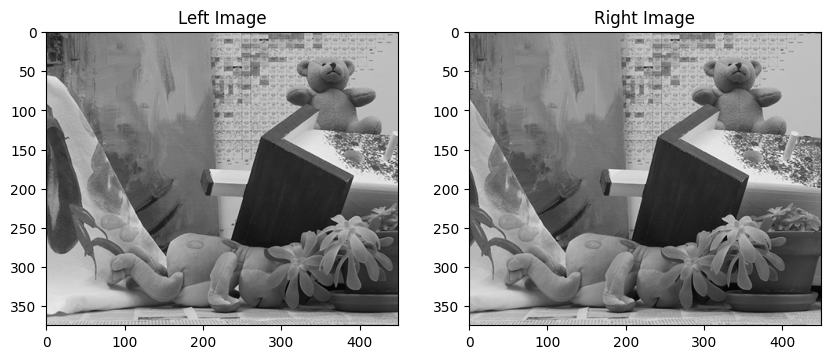

In [21]:
import cv2
import matplotlib.pyplot as plt

# Read grayscale images
imgL = cv2.imread('teddy_left.png', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('teddy_right.png', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(imgL, cmap='gray')
plt.title("Left Image")

plt.subplot(1,2,2)
plt.imshow(imgR, cmap='gray')
plt.title("Right Image")
plt.show()


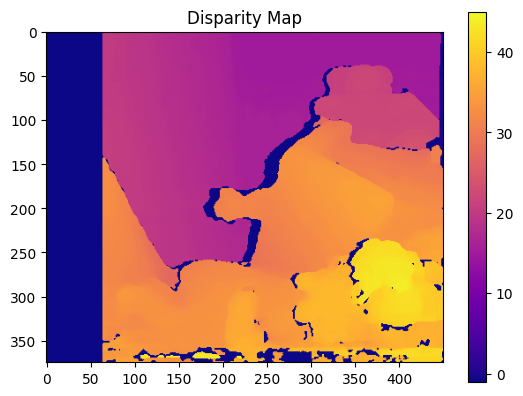

In [22]:
# Initialize SGBM matcher
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=64,  # phải chia hết cho 16
    blockSize=7,
    P1=8 * 3 * 7 ** 2,
    P2=32 * 3 * 7 ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)

disparity = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

# Show disparity map
plt.imshow(disparity, cmap='plasma')
plt.title("Disparity Map")
plt.colorbar()
plt.show()


In [23]:
# Suppose the Q matrix (reprojection matrix)
Q = np.float32([[1, 0, 0, -imgL.shape[1]/2],
                [0, -1, 0, imgL.shape[0]/2],
                [0, 0, 0, -1000],   # -focal length
                [0, 0, 1, 0]])

points_3D = cv2.reprojectImageTo3D(disparity, Q)
mask = disparity > disparity.min()
output = points_3D[mask]

print(f"Point cloud shape: {output.shape}")


Point cloud shape: (138480, 3)


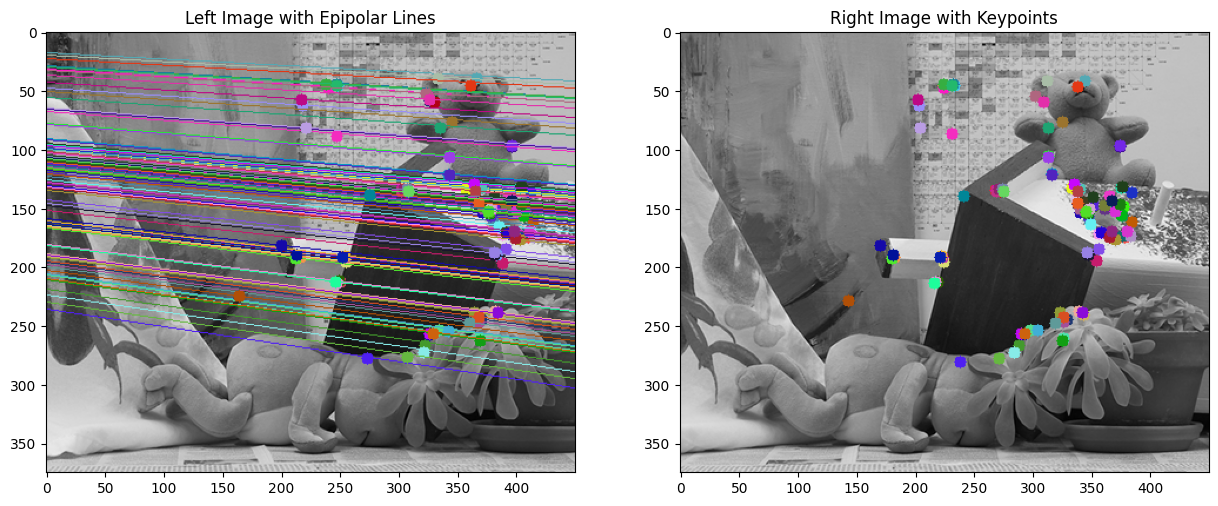

In [24]:
# ORB feature detection
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(imgL, None)
kp2, des2 = orb.detectAndCompute(imgR, None)

# Use BFMatcher to combine features
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf.knnMatch(des1, des2, k=2)

# Apply Lowe’s ratio test
good = []
pts1 = []
pts2 = []
for m,n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# Basic matrix estimation
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Draw epipolar lines
def draw_epilines(img1, img2, lines, pts1, pts2):
    ''' Vẽ epipolar lines trên img1 và các điểm tương ứng trên img2 '''
    r, c = img1.shape
    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1_color = cv2.line(img1_color, (x0,y0), (x1,y1), color, 1)
        img1_color = cv2.circle(img1_color, tuple(pt1), 5, color, -1)
        img2_color = cv2.circle(img2_color, tuple(pt2), 5, color, -1)
    return img1_color, img2_color

# Choose inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# Draw epilines on the left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1,3)
img5, img6 = draw_epilines(imgL, imgR, lines1, pts1, pts2)

# Show
plt.figure(figsize=(15,6))
plt.subplot(1,2,1), plt.imshow(img5), plt.title('Left Image with Epipolar Lines')
plt.subplot(1,2,2), plt.imshow(img6), plt.title('Right Image with Keypoints')
plt.show()


Part C – Image Stitching

In [65]:
from google.colab import files

# Upload images
uploaded = files.upload()

Saving 1.jpg to 1.jpg
Saving 2.jpg to 2.jpg
Saving 3.jpg to 3.jpg
Saving 4.jpg to 4.jpg


In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [67]:
# Load 4 overlapping images and resize them for consistency
image_files = ['1.jpg', '2.jpg', '3.jpg', '4.jpg']
images = [cv2.imread(img) for img in image_files]
images = [cv2.resize(img, (600, 400)) for img in images]

print("Loaded", len(images), "images.")

Loaded 4 images.


In [68]:
# This function detects features, matches keypoints, and estimates homography using RANSAC
def detect_and_match(img1, img2, method='ORB', show_matches=False):
    if method == 'ORB':
        detector = cv2.ORB_create(3000)
        norm_type = cv2.NORM_HAMMING
    elif method == 'SIFT':
        detector = cv2.SIFT_create()
        norm_type = cv2.NORM_L2

    # Detect keypoints and descriptors
    kp1, des1 = detector.detectAndCompute(img1, None)
    kp2, des2 = detector.detectAndCompute(img2, None)

    # Match descriptors
    matcher = cv2.BFMatcher(norm_type, crossCheck=True)
    matches = matcher.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw top 20 matches (optional)
    if show_matches:
        match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=2)
        plt.figure(figsize=(14,6))
        plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Top 20 Matches - {method}")
        plt.axis("off")
        plt.show()

    # Extract matching keypoints
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    # Estimate Homography using RANSAC
    H, mask = cv2.findHomography(pts2, pts1, cv2.RANSAC)
    inliers = int(np.sum(mask)) if mask is not None else 0

    return H, matches, inliers


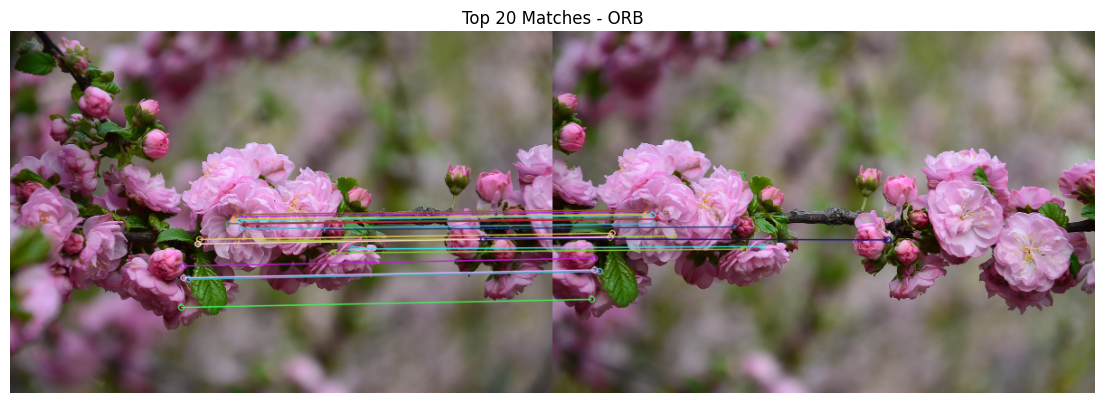

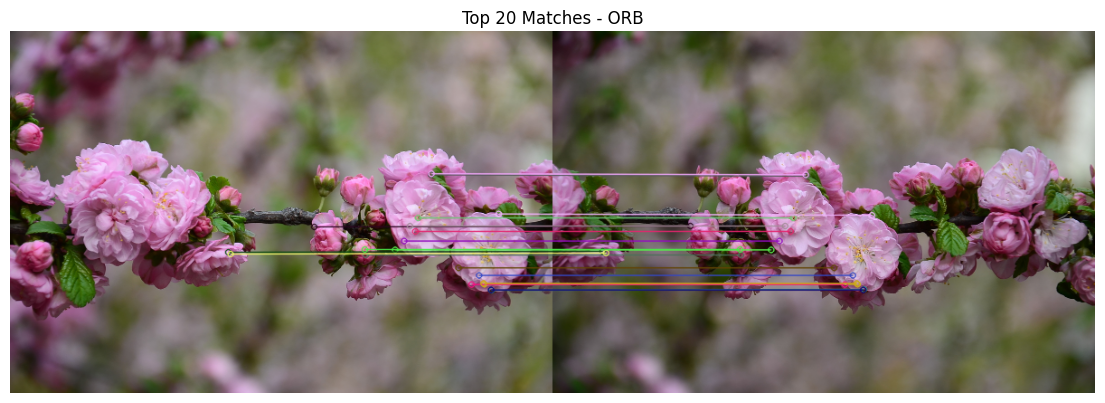

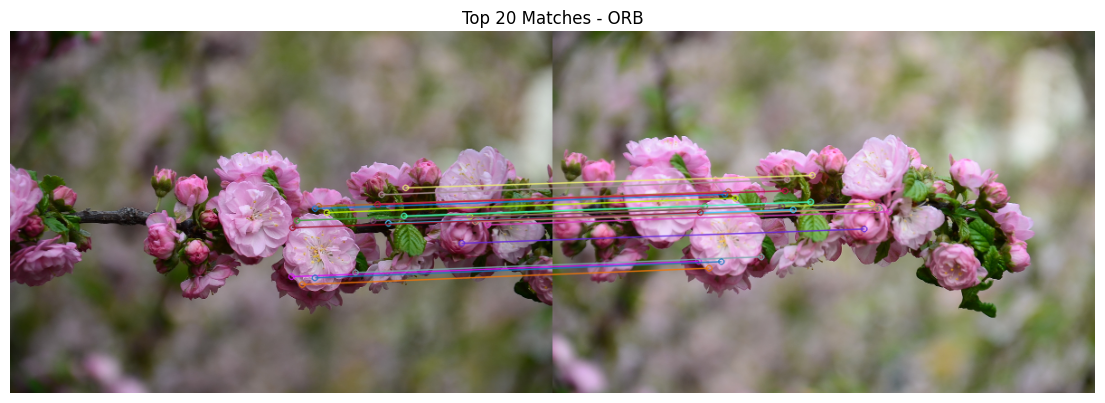

In [69]:
# Compute homographies between adjacent image pairs using ORB
H12, matches12, inliers12 = detect_and_match(images[0], images[1], method='ORB', show_matches=True)
H23, matches23, inliers23 = detect_and_match(images[1], images[2], method='ORB', show_matches=True)
H34, matches34, inliers34 = detect_and_match(images[2], images[3], method='ORB', show_matches=True)

# Compute cumulative homographies to align all to the first image
H13 = H12 @ H23
H14 = H13 @ H34

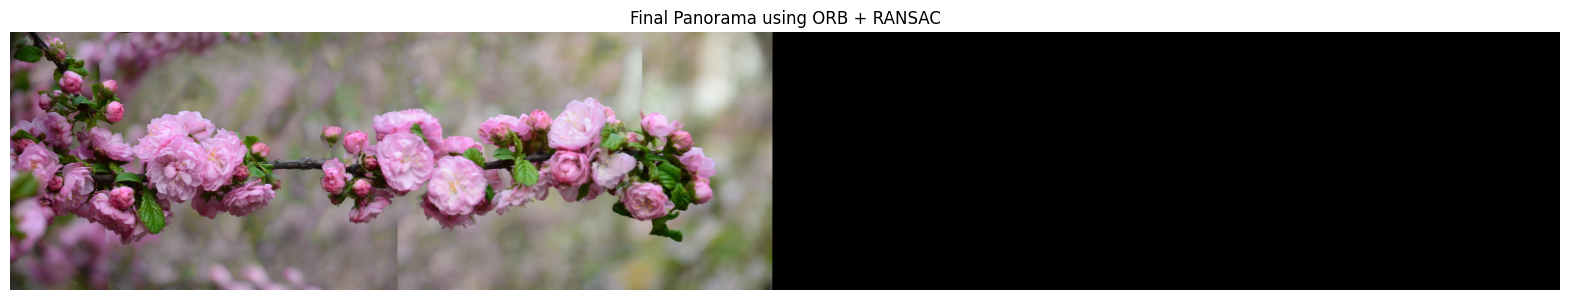

In [70]:
# Create canvas for panorama
h, w = images[0].shape[:2]
panorama = cv2.warpPerspective(images[3], H14, (w * 4, h))
panorama[0:h, 0:w] = images[0]

# Warp intermediate images
warp2 = cv2.warpPerspective(images[1], H12, (w * 4, h))
warp3 = cv2.warpPerspective(images[2], H13, (w * 4, h))

# Blend images by taking maximum pixel values
panorama = np.maximum(panorama, warp2)
panorama = np.maximum(panorama, warp3)

# Show final panorama
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title("Final Panorama using ORB + RANSAC")
plt.axis("off")
plt.show()


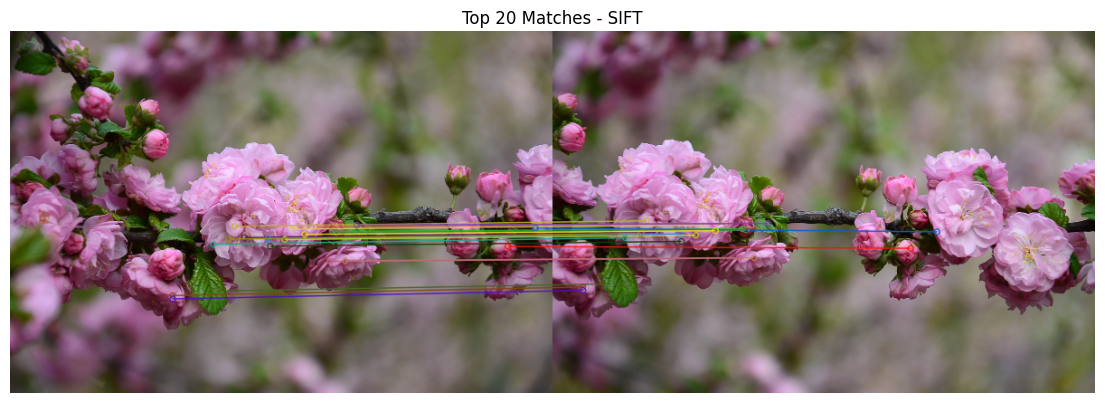

ORB Inliers (1-2): 628
SIFT Inliers (1-2): 307


In [71]:
# Compare SIFT vs ORB (number of inliers)
_, _, sift_inliers12 = detect_and_match(images[0], images[1], method='SIFT', show_matches=True)

print("ORB Inliers (1-2):", inliers12)
print("SIFT Inliers (1-2):", sift_inliers12)